In [1]:
import torch
from tqdm import tqdm
from stable_baselines3 import PPO, SAC

from stable_baselines3.common.callbacks import EvalCallback

import os
import sys
sys.path.append(os.path.pardir)

from cpm_torch.CPM_Image import *
from cpm_torch.CPM import *
from cpm_torch.CPMEnv import *
from cpm_torch.Training.CPM_PPO import *
from cpm_torch.Training.CPM_Policy import *
from cpm_torch.Training.CPM_SAC_Policy import *

error: XDG_RUNTIME_DIR not set in the environment.


In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPUを利用します: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("CPUを利用します")

config = CPM_config(
    size=(64, 64),  # 画像サイズ
    l_A=1.0,  # 面積エネルギー項の係数λ_A
    l_L=1.0,  # 周囲長エネルギー項の係数λ_L
    A_0=75.0,  # 目標細胞面積 A_0
    L_0=40.0,  # 目標細胞周囲長 L_0
    T=1.0,  # 温度パラメータ T
)
print(config.__dict__)

GPUを利用します: NVIDIA H100 PCIe
{'size': (64, 64), 'dim': 2, 'height': 64, 'width': 64, 'depth': 1, 'l_A': 1.0, 'l_L': 1.0, 'A_0': 75.0, 'L_0': 40.0, 'T': 1.0}


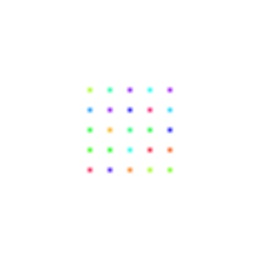

In [3]:
env = CPMEnv(config, device=device)  # CPM環境のインスタンスを作成
env.reset()  # 環境をリセット
env.render()  # 環境を描画

  0%|          | 0/10 [00:00<?, ?it/s]/app/cpm_torch/CPMEnv.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  action = torch.tensor(action, dtype=torch.float32, device=self.device)


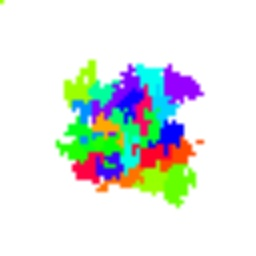

 10%|█         | 1/10 [00:00<00:02,  4.04it/s]

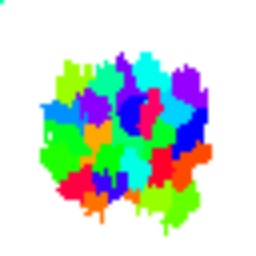

 20%|██        | 2/10 [00:00<00:01,  5.55it/s]

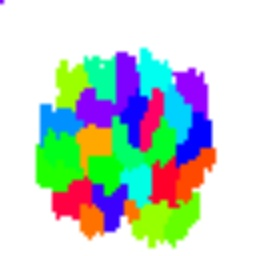

 30%|███       | 3/10 [00:00<00:01,  6.30it/s]

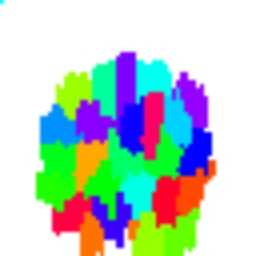

 40%|████      | 4/10 [00:00<00:00,  6.67it/s]

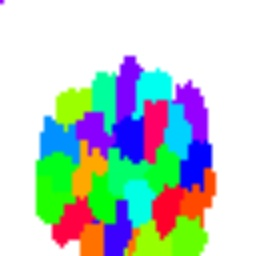

 50%|█████     | 5/10 [00:00<00:00,  6.90it/s]

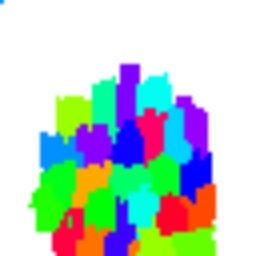

 60%|██████    | 6/10 [00:00<00:00,  6.92it/s]

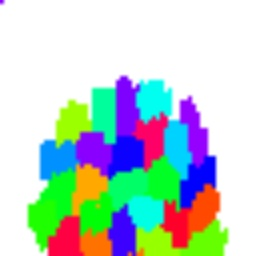

 70%|███████   | 7/10 [00:01<00:00,  7.01it/s]

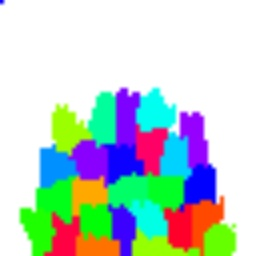

 80%|████████  | 8/10 [00:01<00:00,  7.05it/s]

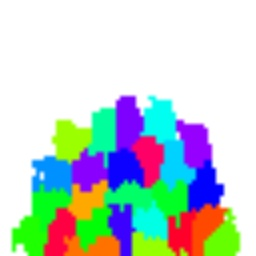

 90%|█████████ | 9/10 [00:01<00:00,  7.15it/s]

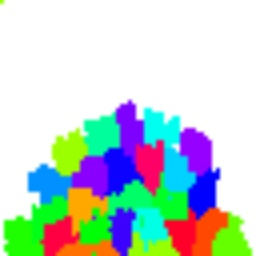

100%|██████████| 10/10 [00:01<00:00,  6.76it/s]


In [4]:
for i in tqdm(range(10)):
    for j in range(100):
        action = torch.zeros((env.action_space.shape[0],), device='cuda')  # ゼロアクションを生成
        action = action.reshape(-1, 4)
        #print("shape:", action.shape)  # アクションの形状を表示
        action[:, 0] = -300.0  # アクションの最初の要素を1.0に設定
        action.flatten()  # アクションをフラット化
        obs, reward, done, _ , info = env.step(action)
    imshow_map(obs)

In [5]:
def vectorized_row_unique_rank_by_appearance(x: torch.Tensor) -> torch.Tensor:
    """
    ベクトル化された手法で各行の出現順ランクを計算する関数。
    ランクは0から始まる整数です。同じ値は同じランクになります。
    例: x = torch.tensor([[10, 20, 10, 0, 20]])
        ranks = self.vectorized_row_unique_rank_by_appearance(x)
        # ranks は [[0, 1, 0, 2, 1]] となる (値10がランク0, 値20がランク1, 値0がランク2)
    """
    B, N = x.shape
    device = x.device

    if B == 0:
        return torch.empty((0, N), dtype=torch.int64, device=device)
    if N == 0:
        return torch.empty((B, 0), dtype=torch.int64, device=device)

    cols_broadcast = torch.arange(N, device=device).view(1, 1, N).expand(B, N, N)
    eq_mask = x.unsqueeze(2) == x.unsqueeze(1)

    sentinel = N 
    masked_cols = torch.where(eq_mask, cols_broadcast, sentinel)
    mci = masked_cols.min(dim=2).values

    A = mci
    S_values, S_indices = A.sort(dim=1)

    R_sorted = torch.zeros_like(A, dtype=torch.int64)
    if N > 1:
        R_sorted[:, 1:] = (S_values[:, 1:] != S_values[:, :-1]).cumsum(dim=1)

    R_final = torch.empty_like(A, dtype=torch.int64)
    R_final.scatter_(dim=1, index=S_indices, src=R_sorted)
    return R_final

def patch_unique(map_patched: torch.Tensor) -> torch.Tensor:
    """
    パッチごとに新しいルールでユニークなIDを割り当てる。
    ルールは前回の説明通り（同じ値には同じID、中央値優先など）。
    """
    original_shape = map_patched.shape
    original_ndim = map_patched.ndim
    
    n_elements_in_patch = 0 

    if original_ndim == 4: 
        num_items = original_shape[0] * original_shape[1]
        n_elements_in_patch = original_shape[2]
        num_channels = original_shape[3]
        reshaped_map_patched = map_patched.reshape(num_items, n_elements_in_patch, num_channels)
    elif original_ndim == 3: 
        num_items = original_shape[0]
        n_elements_in_patch = original_shape[1]
        num_channels = original_shape[2]
        reshaped_map_patched = map_patched
    elif original_ndim == 2 and map_patched.is_contiguous(): 
        num_items = original_shape[0]
        n_elements_in_patch = original_shape[1]
        num_channels = 1 
        reshaped_map_patched = map_patched.unsqueeze(-1)
    else:
        if torch.numel(map_patched) == 0 : 
            return map_patched 
        raise ValueError(
            f"Input tensor map_patched has an unsupported shape: {original_shape}. "
            "Expected 2D (ITEMS, N), 3D (ITEMS, N, C), or 4D (B, P, N, C)."
        )

    _in_data = reshaped_map_patched[:, :, 0].clone() 
    
    B, N = _in_data.shape 
    device = _in_data.device
    
    if B == 0 or N == 0:
        if original_ndim == 2 and num_channels == 1: 
            return reshaped_map_patched.squeeze(-1)
        return reshaped_map_patched 

    R_all_values_rank = vectorized_row_unique_rank_by_appearance(_in_data)

    final_ids = torch.zeros_like(_in_data, dtype=torch.int64, device=device)
    center_idx = N // 2
    
    center_value_per_row = _in_data[:, center_idx].unsqueeze(1) 
    is_center_value_nonzero = (center_value_per_row != 0)      
    next_base_id_for_others = torch.where(is_center_value_nonzero,
                                        torch.tensor(2, dtype=torch.int64, device=device),
                                        torch.tensor(1, dtype=torch.int64, device=device)) 

    rank_of_center_value = R_all_values_rank[:, center_idx].unsqueeze(1)
    
    placeholder_rank_for_missing_zero = R_all_values_rank.max().item() + 1 
    
    R_masked_for_zero_val_rank = torch.where(_in_data == 0, R_all_values_rank, placeholder_rank_for_missing_zero)
    rank_of_zero_value, _ = R_masked_for_zero_val_rank.min(dim=1, keepdim=True) 
    zero_value_exists = (rank_of_zero_value < placeholder_rank_for_missing_zero) 

    shift_amount = torch.zeros_like(R_all_values_rank, dtype=torch.int64) 
    
    shift_due_to_zero = (R_all_values_rank > rank_of_zero_value) & zero_value_exists
    shift_amount += shift_due_to_zero.long()
    
    shift_due_to_center_value = (R_all_values_rank > rank_of_center_value) & is_center_value_nonzero
    shift_amount += shift_due_to_center_value.long()

    adjusted_rank_for_others = R_all_values_rank - shift_amount
    ids_candidate_for_others = adjusted_rank_for_others + next_base_id_for_others

    final_ids = ids_candidate_for_others
    
    mask_value_is_center_value = (_in_data == center_value_per_row) 
    final_ids = torch.where(mask_value_is_center_value & is_center_value_nonzero,
                            torch.tensor(1, dtype=torch.int64, device=device),
                            final_ids)
    
    final_ids[_in_data == 0] = 0 
    
    reshaped_map_patched[:, :, 0] = final_ids.to(reshaped_map_patched.dtype)
    
    if original_ndim == 2 and num_channels == 1 and map_patched.is_contiguous():
            return reshaped_map_patched.squeeze(-1) 
    
    return reshaped_map_patched

In [6]:
obs = obs.unsqueeze(0)  # バッチ次元を追加
print(obs.shape)  # 最後の観測の形状を表示

torch.Size([1, 64, 64, 1])


In [7]:
iter_in_mcs = int(obs[0, 0, 0, 0] - int(obs[0, 0, 0, 0] / 10**2) * 10**2)
obs[0, 0, 0, 0] = (obs[0, 0, 0, 0] - iter_in_mcs) / 10**2

In [9]:


# パッチに分割 (B, 256, 256, C) -> (B, 7396, 9, C)
map_patched = extract_patches_manual_padding_with_offset_batch(
    obs, 3, 3, iter_in_mcs % 3, (iter_in_mcs // 3) % 3
)

# 相対的なIDに変換
half = map_patched.shape[1] // 2
print(half + 100)

print(map_patched.shape)

a = map_patched.clone()
    
map_patched1 = patch_unique(map_patched) # (B*7396, 9, C)
print(map_patched1.shape)
for i in range(340, 484):
    print(a[:, i, :, 0])
    print(map_patched1[i, :, 0])
    print("----")

342
torch.Size([1, 484, 9, 1])
torch.Size([484, 9, 1])
tensor([[ 8.,  8.,  8.,  8.,  8.,  8.,  8., 13., 13.]])
tensor([1., 1., 1., 1., 1., 1., 1., 2., 2.])
----
tensor([[ 8.,  8.,  8., 13., 13.,  8., 13., 13., 13.]])
tensor([2., 2., 2., 1., 1., 2., 1., 1., 1.])
----
tensor([[9., 9., 9., 9., 9., 9., 9., 9., 9.]])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1.])
----
tensor([[ 9., 14., 10.,  9., 14., 10.,  9., 14., 10.]])
tensor([2., 1., 3., 2., 1., 3., 2., 1., 3.])
----
tensor([[10., 10., 10., 10., 10., 10., 10., 10., 10.]])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1.])
----
tensor([[10., 10., 10., 10., 10., 10., 10., 10., 10.]])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1.])
----
tensor([[10., 15., 15., 10., 15., 15., 15., 15., 15.]])
tensor([2., 1., 1., 2., 1., 1., 1., 1., 1.])
----
tensor([[15., 15., 15., 15., 15., 15., 15., 15., 15.]])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1.])
----
tensor([[15.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0.])
----
